In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from dateutil.parser import parse
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import as Dataframe
folder_path='../input/store-sales-time-series-forecasting'

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

df=pd.read_csv(folder_path+'/train.csv',
                       dtype=dtype,
                       parse_dates=['date'],
                       infer_datetime_format=True)
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


Checking for missing values in the dataset

In [3]:
df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Our task is to forecast monthly total sales. We need to aggregate our data at the monthly level and sum up the sales column.

In [4]:
#represent month in date field as its first day
df['date'] = df['date'].dt.year.astype('str') + '-' + df['date'].dt.month.astype('str') + '-01'
df['date'] = pd.to_datetime(df['date'])
#groupby date and sum the sales
df = df.groupby('date').sales.sum().reset_index()

In [5]:
df.head()

,date,sales
0,2013-01-01,10327625.0
1,2013-02-01,9658960.0
2,2013-03-01,11428497.0
3,2013-04-01,10993465.0
4,2013-05-01,11597704.0


## Visualizing a time series
Let’s use matplotlib to visualise the series.

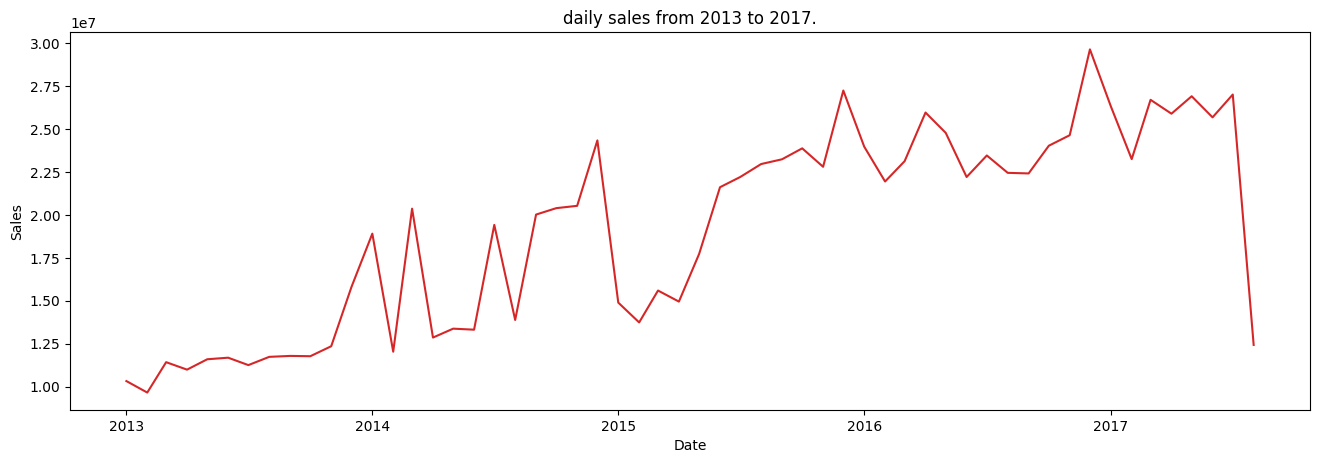

In [6]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Sales', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df['date'], y=df.sales, title='daily sales from 2013 to 2017.') 

We Can see clearly that our data have trend and seasonality

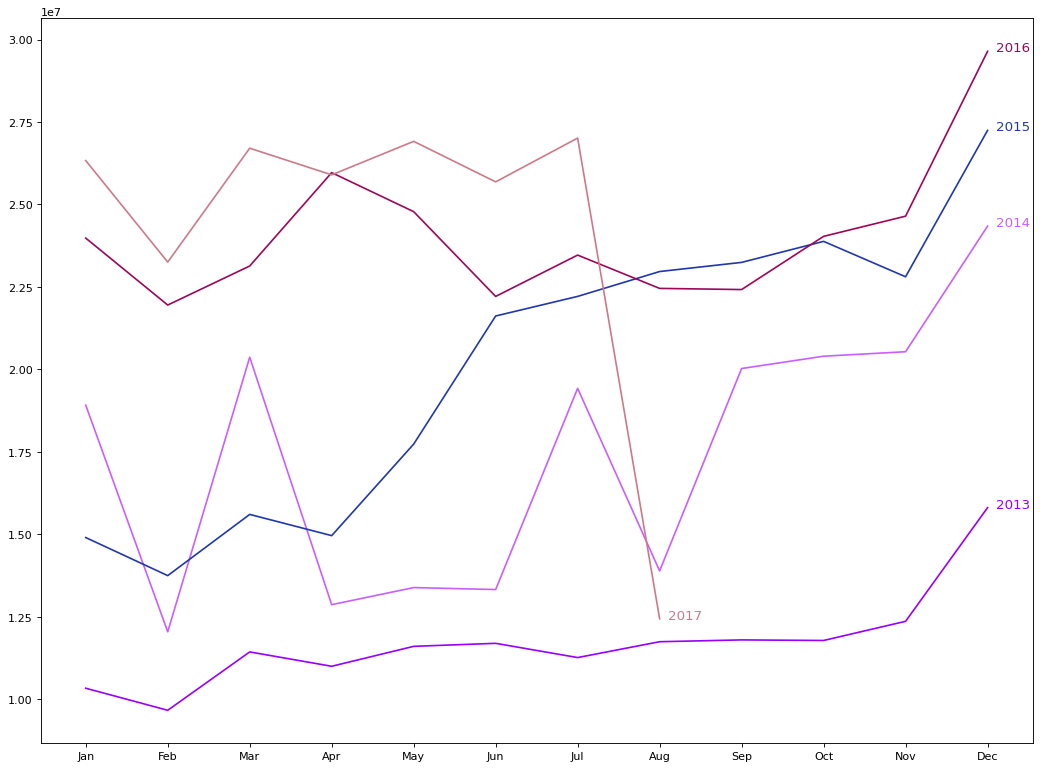

In [7]:
# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):   
    plt.plot('month', 'sales', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
    plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'sales'][-1:].values[0], y, fontsize=12, color=mycolors[i])

There is a steep fall in sales every February, rising again in March, falling again in April and so on. Clearly, the pattern repeats within a given year, every year. However, as years progress, the sales increase overall. You can nicely visualize this trend and how it varies each year in a nice year-wise boxplot. Likewise, you can do a month-wise boxplot to visualize the monthly distributions. Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution You can group the data at seasonal intervals and see how the values are distributed within a given year or month and how it compares over time.

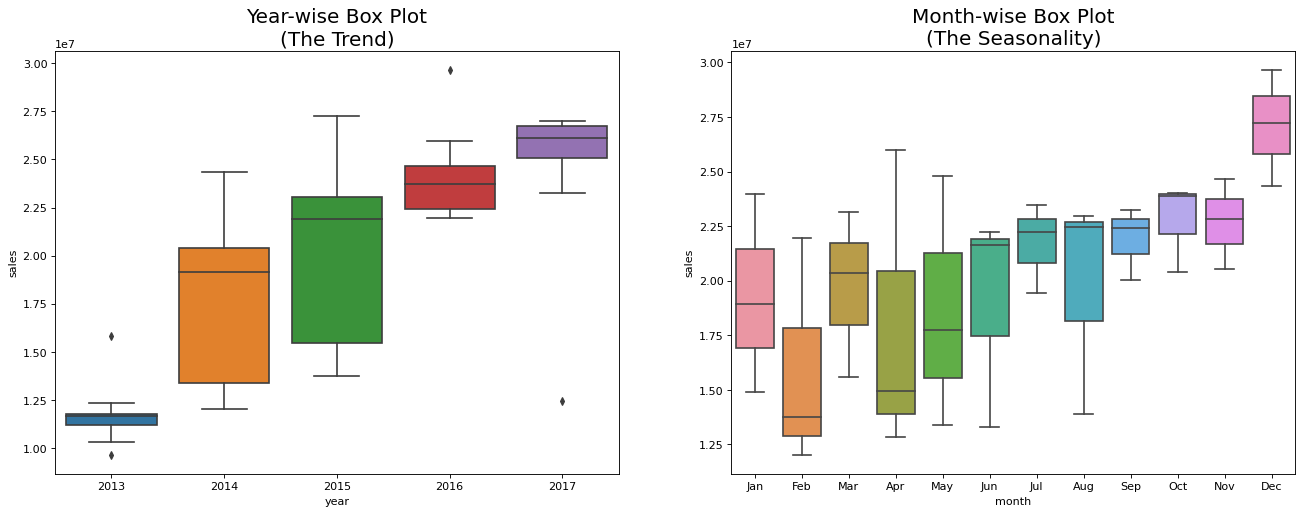

In [8]:
# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='sales', data=df, ax=axes[0])
sns.boxplot(x='month', y='sales', data=df.loc[~df.year.isin([2013, 2017]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

The boxplots make the year-wise and month-wise distributions evident. Also, in a month-wise boxplot, the months of December and April clearly has higher sales, which can be attributed to the holiday discounts season. So far, we have seen the similarities to identify the pattern. Now, how to find out any deviations from the usual pattern?

Now we do a classical decomposition of a time series by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual

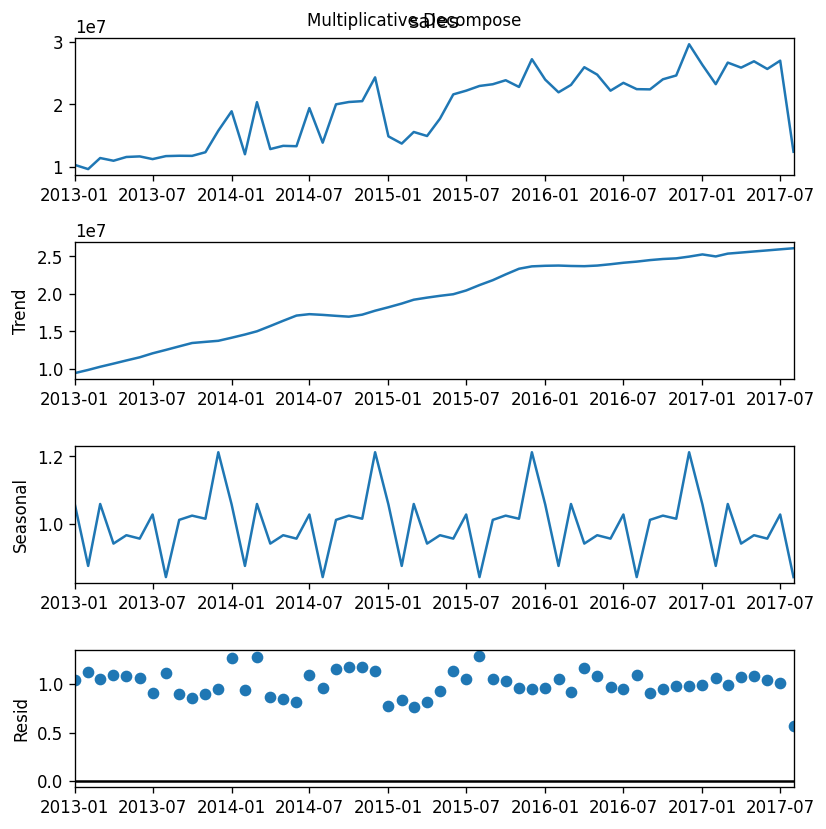

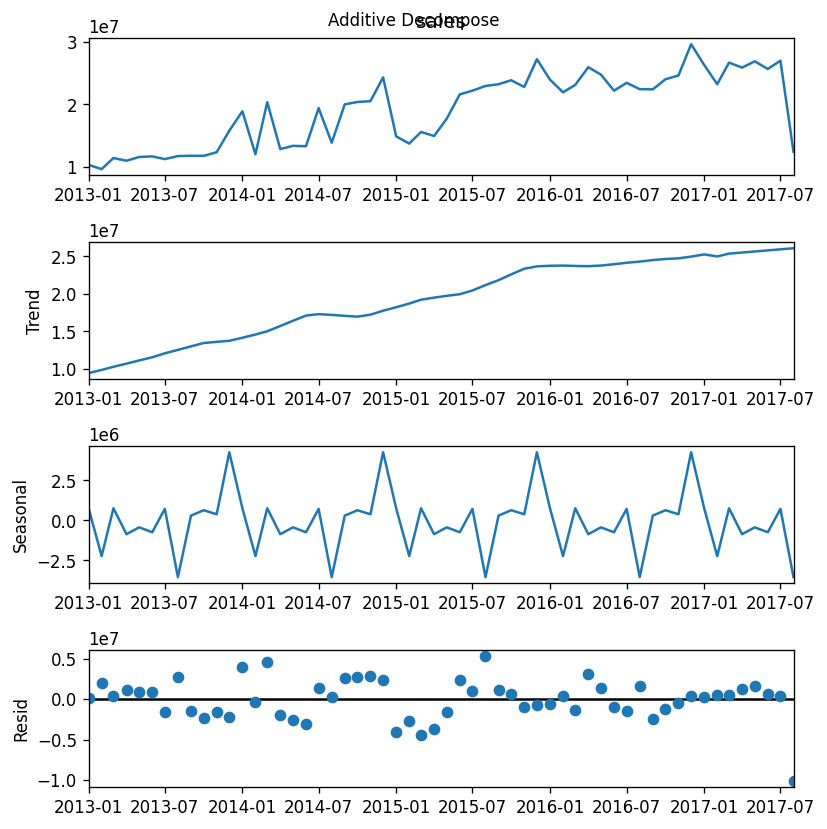

In [9]:
df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['sales'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['sales'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (7,7)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)
result_add.plot().suptitle('Additive Decompose', fontsize=10)
plt.show()

### Test for stationarity

In [10]:
result = adfuller(df.sales.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.045286915569153
p-value: 0.26707593004685903
Critial Values:
   1%, -3.55770911573439
Critial Values:
   5%, -2.9167703434435808
Critial Values:
   10%, -2.59622219478738


where the null hypothesis is the time series possesses a unit root and is non-stationary. So, we have the P-Value > 0.05 in ADH test, we accept the null hypothesis.

In [11]:
#create a new dataframe to model the difference
df_diff = df.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])
df_diff.head(10)

,date,sales,year,month,prev_sales,diff
date,,,,,,
2013-02-01,2013-02-01,9658960.0,2013,Feb,10327625.0,-668665.0
2013-03-01,2013-03-01,11428497.0,2013,Mar,9658960.0,1769537.0
2013-04-01,2013-04-01,10993465.0,2013,Apr,11428497.0,-435032.0
2013-05-01,2013-05-01,11597704.0,2013,May,10993465.0,604239.0
2013-06-01,2013-06-01,11689344.0,2013,Jun,11597704.0,91640.0
2013-07-01,2013-07-01,11257401.0,2013,Jul,11689344.0,-431943.0
2013-08-01,2013-08-01,11737789.0,2013,Aug,11257401.0,480388.0
2013-09-01,2013-09-01,11792933.0,2013,Sep,11737789.0,55144.0
2013-10-01,2013-10-01,11775620.0,2013,Oct,11792933.0,-17313.0


Let’s check if it is stationary now:

In [12]:
result = adfuller(df_diff['diff'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -10.042408765986078
p-value: 1.4843200406669865e-17
Critial Values:
   1%, -3.55770911573439
Critial Values:
   5%, -2.9167703434435808
Critial Values:
   10%, -2.59622219478738


Now the null hypothesis is the time series possesses a unit root and is non-stationary. So, the P-Value in ADH test is less than the significance level (0.05), we reject the null hypothesis.

In [13]:
# 1,1,2 ARIMA Model
model = ARIMA(df['sales'], order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                   55
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -905.016
Method:                       css-mle   S.D. of innovations        3375341.683
Date:                Tue, 28 May 2024   AIC                           1818.033
Time:                        08:43:41   BIC                           1826.062
Sample:                    02-01-2013   HQIC                          1821.138
                         - 08-01-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.829e+04        nan        nan        nan         nan         nan
ar.L1.D.sales     0.0677        nan        nan        nan         nan         nan
ma.L1.D.sales    -0.6330        nan     

The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

Notice here the coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

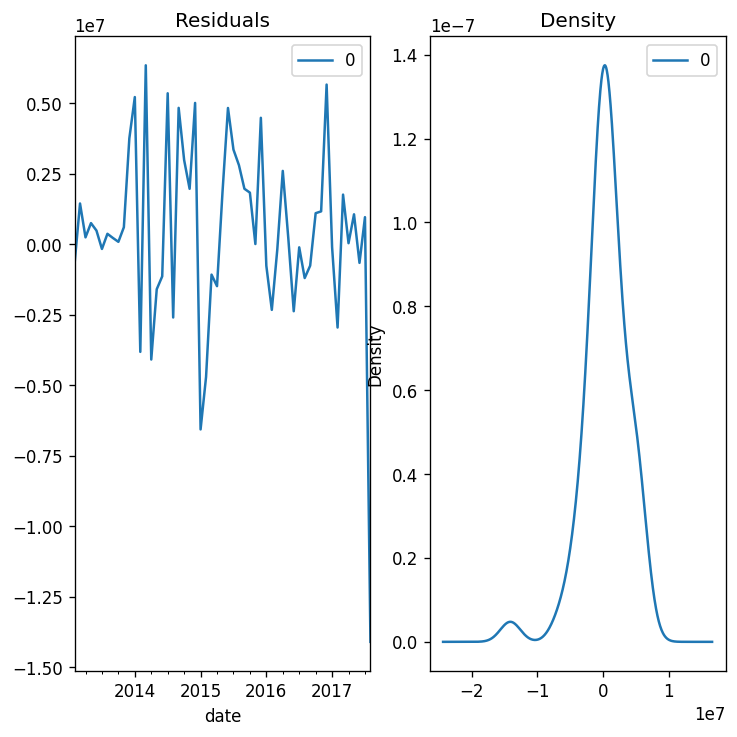

In [14]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

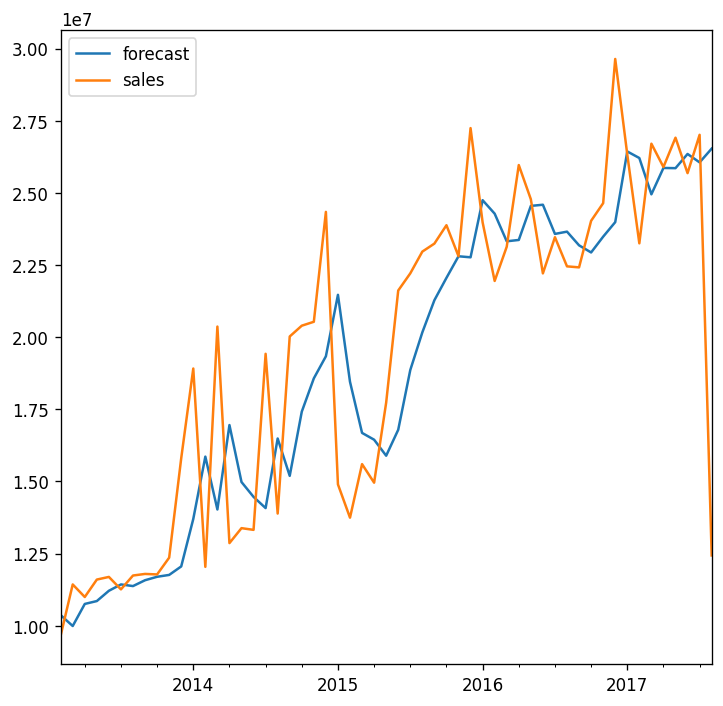

In [15]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

So, let’s rebuild the model without the MA2 term.

In [16]:
# 5,2,1 ARIMA Model
model = ARIMA(df['sales'], order=(5,2,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.sales   No. Observations:                   54
Model:                 ARIMA(5, 2, 2)   Log Likelihood                -894.325
Method:                       css-mle   S.D. of innovations        3706073.716
Date:                Tue, 28 May 2024   AIC                           1806.650
Time:                        08:43:42   BIC                           1824.551
Sample:                    03-01-2013   HQIC                          1813.554
                         - 08-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.576e+05        nan        nan        nan         nan         nan
ar.L1.D2.sales    -0.3735      0.494     -0.756      0.449      -1.341       0.594
ar.L2.D2.sales    -0.2106      0.277

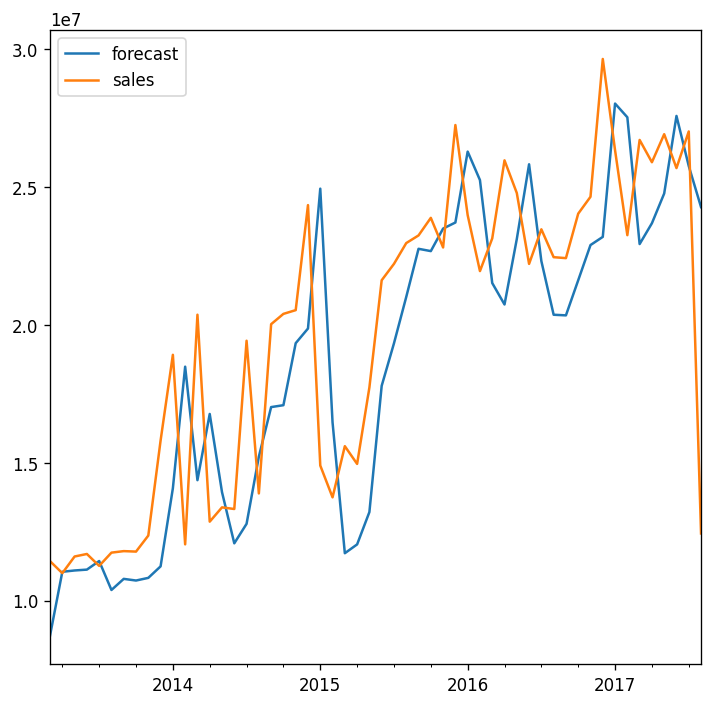

In [17]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()